# Importation des données

In [41]:
import os
import string
import re
import math
from math import sqrt
import numpy as np
import random
import time
random.seed(1)
import pandas as pd

os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
df = pd.read_csv("data/sample_3.txt",sep='\n',header=None)
print(string.punctuation + "'’")
def mise_en_forme_phrase (phrase):
    phrase = str(phrase)
    phrase = phrase.lower()
    # On enlève la ponctuation mais ça peut se discuter (garder les @ et #?)
    phrase = re.sub('( @[^ ]*)|(^@[^ ]*)',"nickname", phrase) #Remplace @... par nickname
    # On enlève la ponctuation + certaines apostrophes
    phrase = phrase.translate(str.maketrans('', '', string.punctuation + "'’"))
    # On enlève les passages à la ligne
    phrase = re.sub('\\n', ' ', phrase)
    # On enlève les espaces multiples et les espaces à la fin des phrases
    phrase = re.sub(' +', ' ', phrase)
    phrase = re.sub(' +$', '', phrase)
    phrase.isalpha()
    return(phrase.split())
phrases = []
for index, row in df.iterrows():
    for j, column in row.iteritems():
        phrases.append(mise_en_forme_phrase(column))
        
#phrases = phrases[0:10000]
#phrases = df2.apply(mise_en_forme_phrase)

print(phrases[0:10])
#raw = ''.join([''.join(phrase) for phrase in phrases])

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'’


In [2]:
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
# words = word_tokenize(raw) # Plus utile maintenant
words = [item for sublist in phrases for item in sublist]
print(type(words))
## On enlève la ponctuation et on met en minuscule :
#words = [word.lower() for word in words if word.isalpha()] # plus utile maintenant
vocabulary = set(words)

<class 'list'>


In [3]:
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))

Nombre de mots : 109479
Taille du vocabulaire : 13546


Les 10 mots les plus communs sont :
[('nickname', 4457), ('de', 3938), ('le', 2548), ('est', 2144), ('je', 2037), ('les', 1813), ('j', 1785), ('à', 1721), ('c', 1693), ('la', 1620)]


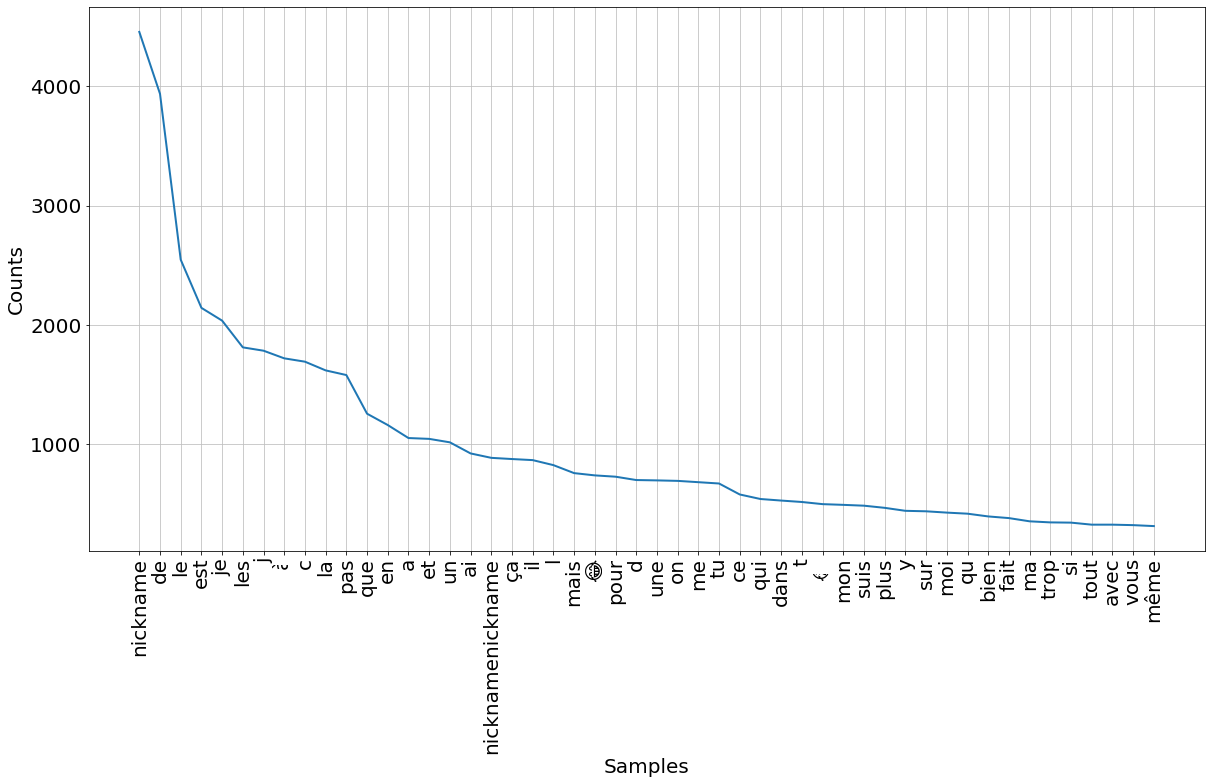

In [4]:
# Pour changer la taille des graphiques :
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.size"] = 20

fdist = nltk.FreqDist(words)
print("Les 10 mots les plus communs sont :")
print(fdist.most_common(10))
fdist.plot(50)

# Sampling rate
On va simplifier un peu le corpus en enlevant certains mots. Pour cela on va faire un sous-échantillonnage du corpus pour supprimer certains mots. 

Pour chaque mot $w_i$ on note $z(w_i)$ la proportion d'apparition de ce mot, c'est-à-dire le rapport entre le nombre de fois que ce mot apparait et le nombre total de mots. La probabilité de garder un mot le mot $w_i$ est :
$$
\mathbb P(w_i) = \left(\sqrt{\frac{z(w_i)}{q}} + 1 \right)
\times
\frac{q}{z(w_i)}
$$
Le paramètre $q$ est appelé "sample" – échantillonnage – contrôle le nombre de sous-échantillonnages. La valeur par défaut est 0,001.

In [5]:
def calcul_proba(x):
    result = (sqrt(x)+1)*(1/x)
    return(result)
calcul_proba_v = np.vectorize(calcul_proba) # Pour vectoriser la fonction

# Génération de l'échantillon de test
Comment on gère les doublons ?

In [6]:
def creer_echantillon(phrases, vocabulary , probabilities_subsampling,  window = 2):
    #Sub-sampling
    nouveau_corpus = [] 
    for phrase in phrases: #on parcourt tous les articles du corpus
        nouveau_corpus.append([]) #on crée une sous liste à chaque nouvel article
        for word in phrase: #et pour tous les mots de l'article
        # Les mots à supprimer sont les mots tels que la loi générée U([0,1]) soit > proba
        # On garde donc les mots si U([0,1]) <= proba
            proba_w = probabilities_subsampling[vocabulary.index(word)]
            if np.random.uniform(low=0.0, high=1.0) <= proba_w: # Je garde le mot
                nouveau_corpus[-1].append(word) 
    phrases = [phrase for phrase in nouveau_corpus if len(phrase)>1] # On enlève les phrases avec 1 seul mot
    test_sample = []
    for phrase in phrases:
        # Pour chaque phrase on prend au hasard un mot focus et un mot contexte
        focus = list(range(0, len(phrase)))
        focus = random.choice(focus)
        i = focus
        index_i = vocabulary.index(phrase[i])
        i_contexte = list(range(max(i-window,0), min(i+window+1, len(phrase))))
        i_contexte.remove(i)
        i_contexte = random.choice(i_contexte)
        j = i_contexte
        index_j = vocabulary.index(phrase[j])
        test_sample.append([index_i, index_j])
    return(test_sample)

# Algorithme avec softmax
Si on note $\theta$ le paramètre à estimer, $L(\theta)$ la fonction de perte et $\eta$ le taux d'apprentissage (*learning rate*) alors :
$$
\theta^{(t+1)} = \theta^{(t)} - \eta \nabla_\theta L(\theta^{(t)})
$$

Pour le négative sampling, la probabilité de garder le mot $w_i$ est égale à :
$$
\mathbb P(w_i) = \frac{f(w_i)^{3/4}}{
\sum_{j=1}^n f(w_j)^{3/4}
}
$$
Avec $f(w_j)$ la fréquence d'apparition du mot $w_j$.

In [7]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.show();

In [8]:
# On crée le vocabulaire, on calcule les proba de subsampling et negative sampling
sample = 0.001
words = [item for sublist in phrases for item in sublist]
fdist = nltk.FreqDist(words)
vocabulary = list(set(words))
proportion = np.array([(fdist[w]/ (len(words) * sample)) for w in vocabulary])
p_subsampling = calcul_proba_v(proportion)
p_negativesampling = np.array([(fdist[w]**(3/4)) for w in vocabulary])
p_negativesampling /= p_negativesampling.sum()
len(vocabulary)

13546

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

dim = 10
epoch = 10
learning_rate = 0.01

# Attention: torch.rand génère une loi uniforme et torch.randn une loi normale
input = torch.randn(len(vocabulary), dim)
output = torch.randn(len(vocabulary), dim)
input = autograd.Variable(input, requires_grad=True)
output = autograd.variable(output, requires_grad=True)

loss_tot = []

start = time.time()
for i in range(epoch):
    #print(i)
    loss_val = 0
    test_sample = creer_echantillon(phrases, vocabulary, p_subsampling)
    for focus, context in test_sample:
        # Multiplication matricielle: 
        data = torch.matmul(input[focus,], torch.t(output))
        #log_probs = F.log_softmax(data, dim=0)
        #loss = F.nll_loss(log_probs.view(1,-1), torch.tensor([context]))
        # Il semble que cela combine les deux précédentes fonctions : 
        # https://pytorch.org/docs/stable/nn.functional.html#cross-entropy
        loss = F.cross_entropy(data.view(1,-1), torch.tensor([context]))
        #print(loss)
        loss_val += loss.data
        # Pour ensuite dériver les matrices par rapport à la loss
        loss.backward()
        
        # Il faut modifier juste le .data pour ne pas perdre la structure
        input.data = input.data - learning_rate * input.grad.data
        output.data = output.data - learning_rate * output.grad.data
        
        input.grad.data.zero_()
        output.grad.data.zero_()
    loss_val = loss_val / len(vocabulary)
    loss_tot.append(loss_val)
    live_plot(loss_tot)
end = time.time()
print(round((end - start)/60, 2))
#print(input)        
#plt.plot(loss_tot)

KeyboardInterrupt: 

## Algorithme avec negsampling

Pour le négative sampling, la probabilité de garder le mot $w_i$ est égale à :
$$
\mathbb P(w_i) = \frac{f(w_i)^{3/4}}{
\sum_{j=1}^n f(w_j)^{3/4}
}
$$
Avec $f(w_j)$ la fréquence d'apparition du mot $w_j$.

In [31]:
def tirage_neg_sampling(vocabulary, proba_negativesampling, focus, context, K = 5):
    #proba_negativesampling[focus] = 0
    #proba_negativesampling[context] = 0
    liste_vocab = list(range(len(vocabulary)))
    neg_sampling = np.random.choice(liste_vocab, size=K, p=proba_negativesampling)
   # while( (focus in neg_sampling) | (context in neg_sampling)):
   #     neg_sampling = np.random.choice(liste_vocab, size=K, p=proba_negativesampling)
    return(neg_sampling)

In [32]:
# Test 2
dim = 10
epoch = 50
learning_rate = 0.01
K = 5

def word2vec_1(phrases, dim=10, epoch = 10, learning_rate = 0.01, K = 5, sample = 0.001, window = 2, plot = True):
    words = [item for sublist in phrases for item in sublist]
    fdist = nltk.FreqDist(words)
    vocabulary = list(set(words))
    proportion = np.array([(fdist[w]/ (len(words) * sample)) for w in vocabulary])
    p_subsampling = calcul_proba_v(proportion)
    p_negativesampling = np.array([(fdist[w]**(3/4)) for w in vocabulary])
    p_negativesampling /= p_negativesampling.sum()
    input = torch.randn(len(vocabulary), dim)
    output = torch.randn(len(vocabulary), dim)
    input = autograd.Variable(input, requires_grad=True)
    output = autograd.variable(output, requires_grad=True)

    loss_tot = []

    start = time.time()
    for i in range(epoch):
        #print(i)
        loss_val = 0
        test_sample = creer_echantillon(phrases, vocabulary, p_subsampling, window)
        for focus, context in test_sample:
            neg_sample = tirage_neg_sampling(vocabulary, p_negativesampling,
                                             focus, context,
                                             K = K)
            #vect_sample = np.append(context, neg_sample)
            data = torch.matmul(input[focus,], torch.t(output[context,]))
            loss1 = - F.logsigmoid(data)

            data = torch.matmul(input[focus,], torch.t(output[neg_sample,]))
            loss2 = - F.logsigmoid(-data).sum()
            #print(loss)
            loss_val += loss1 + loss2
            # Pour ensuite dériver les matrices par rapport à la loss
            (loss1+loss2).backward()

            # Il faut modifier juste le .data pour ne pas perdre la structure
            input.data = input.data - learning_rate * input.grad.data
            output.data = output.data - learning_rate * output.grad.data

            input.grad.data.zero_()
            output.grad.data.zero_()
        loss_val = loss_val / len(vocabulary)
        loss_tot.append(loss_val)
        if plot:
            live_plot(loss_tot)
    end = time.time()
    print(round((end - start)/60, 2))
    return(((input + output)/2))
def word2vec_2(phrases, dim=10, epoch = 10, learning_rate = 0.01, K = 5, sample = 0.001, window = 2, plot = True):
    words = [item for sublist in phrases for item in sublist]
    fdist = nltk.FreqDist(words)
    vocabulary = list(set(words))
    proportion = np.array([(fdist[w]/ (len(words) * sample)) for w in vocabulary])
    p_subsampling = calcul_proba_v(proportion)
    p_negativesampling = np.array([(fdist[w]**(3/4)) for w in vocabulary])
    p_negativesampling /= p_negativesampling.sum()
    input = torch.randn(len(vocabulary), dim)
    output = torch.randn(len(vocabulary), dim)
    input = autograd.Variable(input, requires_grad=True)
    output = autograd.variable(output, requires_grad=True)

    loss_tot = []

    start = time.time()
    for i in range(epoch):
        #print(i)
        loss_val = 0
        for phrase in phrases: #on parcourt tous les articles du corpus
            nouvelle_phrase = [] #on crée une sous liste à chaque nouvel article
            for word in phrase: #et pour tous les mots de l'article
            # Les mots à supprimer sont les mots tels que la loi générée U([0,1]) soit > proba
            # On garde donc les mots si U([0,1]) <= proba
                proba_w = p_subsampling[vocabulary.index(word)]
                if np.random.uniform(low=0.0, high=1.0) <= proba_w:
                    nouvelle_phrase.append(word)
            phrase = nouvelle_phrase
            if (len(phrase)>1):
                focus = list(range(0, len(phrase)))
                focus = random.choice(focus)
                i = focus
                index_i = vocabulary.index(phrase[i])
                i_contexte = list(range(max(i-window,0), min(i+window+1, len(phrase))))
                i_contexte.remove(i)
                i_contexte = random.choice(i_contexte)
                j = i_contexte
                index_j = vocabulary.index(phrase[j])

                focus = index_i
                context = index_j

                neg_sample = tirage_neg_sampling(vocabulary, p_negativesampling,
                                                 focus, context,
                                                 K = K)
                vect_sample = np.append(context, neg_sample)
                data = torch.matmul(input[focus,], torch.t(output[context,]))
                loss1 = - F.logsigmoid(data)

                data = torch.matmul(input[focus,], torch.t(output[neg_sample,]))
                loss2 = - F.logsigmoid(-data).sum()
                #print(loss)
                loss_val += loss1 + loss2
                # Pour ensuite dériver les matrices par rapport à la loss
                (loss1+loss2).backward()

                # Il faut modifier juste le .data pour ne pas perdre la structure
                input.data = input.data - learning_rate * input.grad.data
                output.data = output.data - learning_rate * output.grad.data

                input.grad.data.zero_()
                output.grad.data.zero_()
        loss_val = loss_val / len(vocabulary)
        loss_tot.append(loss_val)
        if plot:
            live_plot(loss_tot)
    end = time.time()
    print(round((end - start)/60, 2))
    return(((input + output)/2))

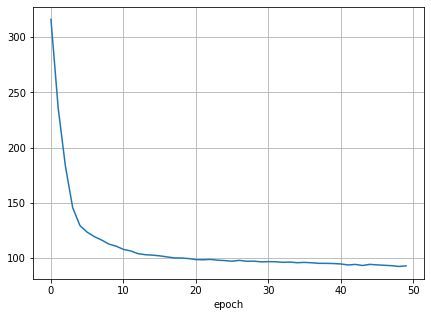

4.35


In [33]:
W3 = word_2_vec(phrases, epoch = 50)

In [145]:

mot_poids = {vocabulary[index]: poids.detach().numpy() for (index, poids) in enumerate(W3)}

def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))
def mot_plus_proche(word, n=10):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            word_distance[mot] = (cos_distance(mot_poids[mot],(mot_poids[word])))
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]

In [146]:
mot_plus_proche("grand")

[('mesure', 0.9950687404516931),
 ('énorme', 0.9903156980369561),
 ('petit', 0.9898449233633478),
 ('taille', 0.989344536290486),
 ('l', 0.9832240175720414),
 ('m', 0.9831311443659951),
 ('nain', 0.9831199280360914),
 ('xl', 0.9830711671364922),
 ('s', 0.9824932168947119),
 ('géant', 0.9673119322111354)]

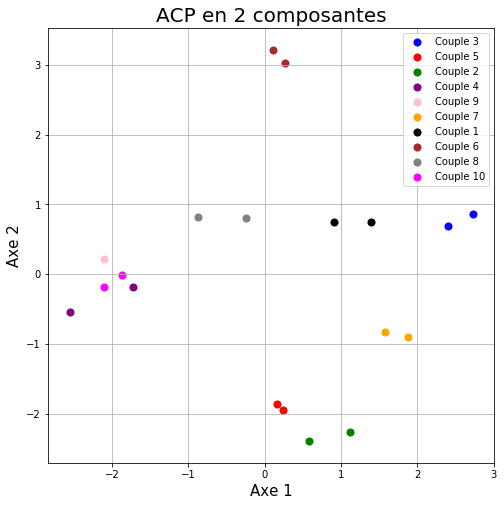

In [148]:
import math
import pandas as pd
liste = ["homme","femme","chien","chat","vanille","chocolat",
    "poli","courtois","choqué","horrifié","propre","sale","canapé","fauteuil",
    "téléphone","portable","voiture","camion","grand","petit"]

df_res = pd.DataFrame.from_dict(mot_poids).transpose()
df_res = df_res.loc[liste]
df_res['label'] = 'Autre' 

df_res.loc["homme",'label'] = 'Couple 1'
df_res.loc["femme",'label'] = 'Couple 1'

df_res.loc["chien",'label'] = 'Couple 2'
df_res.loc["chat",'label'] = 'Couple 2'

df_res.loc["vanille",'label'] = 'Couple 3'
df_res.loc["chocolat",'label'] = 'Couple 3'

df_res.loc["poli",'label'] = 'Couple 4'
df_res.loc["courtois",'label'] = 'Couple 4'

df_res.loc["choqué",'label'] = 'Couple 5'
df_res.loc["horrifié",'label'] = 'Couple 5'

df_res.loc["propre",'label'] = 'Couple 6'
df_res.loc["sale",'label'] = 'Couple 6'

df_res.loc["canapé",'label'] = 'Couple 7'
df_res.loc["fauteuil",'label'] = 'Couple 7'

df_res.loc["téléphone",'label'] = 'Couple 8'
df_res.loc["portable",'label'] = 'Couple 8'

df_res.loc["voiture",'label'] = 'Couple 9'
df_res.loc["camion",'label'] = 'Couple 9'

df_res.loc["grand",'label'] = 'Couple 10'
df_res.loc["petit",'label'] = 'Couple 10'
from sklearn.preprocessing import StandardScaler
features = [0, 1, 2, 3, 4, 5, 6, 7,8 ,9]
# Separating out the features
x = df_res.loc[:, features].values
# Separating out the target
y = df_res.loc[:,['label']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Axe 1', 'Axe 2'])

df_res['mot'] = df_res.index.values
df_res = df_res.reset_index()

finalDf = pd.concat([principalDf, df_res[['label','mot']]],  axis = 1)


# Représentation simple statique 
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Axe 1', fontsize = 15)
ax.set_ylabel('Axe 2', fontsize = 15)
ax.set_title('ACP en 2 composantes', fontsize = 20)
targets = list(set(df_res['label']))
colors = ['blue', 'red', 'green', 'purple', 'pink', 'orange', 'black', 'brown', 'grey', 'magenta']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Axe 1']
               , finalDf.loc[indicesToKeep, 'Axe 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [113]:
torch.matmul(input[focus,], torch.t(output[context,]))

tensor(-2.9552, grad_fn=<DotBackward>)

tensor([ 1.7062,  8.3308, -8.6961, -0.2563, -0.6412,  0.6409],
       grad_fn=<SqueezeBackward3>)

tensor(1.7597, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

tensor(1.3287, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [27]:
from random import *
import random
from random import randrange
from random import sample 

from numpy.random import multinomial
liste_couples = {
    0:("homme","femme"),
    1:("chien","chat"),
    2:("vanille","chocolat"),
    3:("poli","courtois"),
    4:("choqué","horrifié"),
    5:("propre","sale"),
    6:("canapé","fauteuil"),
    7:("téléphone","portable"),
    8:("voiture","camion"),
    9:("grand","petit")
}

couples_contexte = {
("homme","femme") : ["sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],                  
("chien","chat") : ["animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
("vanille","chocolat") : ["parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
("poli","courtois") : ["bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
("choqué","horrifié") : ["peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
("propre","sale") : ["nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
("canapé","fauteuil") : ["maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
("téléphone","portable") : ["appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
("voiture","camion") : ["moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
("grand","petit") : ["taille","géant","nain","s","m","l","xl","mesure","énorme"]
}

bruits = ['ALLATES','NEBULES','LONGTON','PAWESIN','SORENGO','SEXTEES','TAXIONS','ELEWIJT','EPEISME','APOTOME',
'REMORVA','HOBOKEN','MALICES','SOMZEEN','NEDDOIS','RECLIVA','GILEREZ','GAULDOS','GOINFRA','RAYERES','BOTTEES','VAGITES','PRELEES','GARDERA','ANATASE','DATASSE',
'BILLAGE','POUCAVE','REFUGES','REDIMAI','SOLANGE','EMBOISE','BACHAGA','FAMINER','ECUMONS','HARWELL','VEURDES','AZURERA','ENUQUAI','MAULAIS','MEVENIR','GAUDENT',
'MENTANA','REHERSE','ARBECEY','FAUXAMI','BALADOU','REVERDI','BEDAVES','BORAMES','PONTIFE','ALESIEZ','REFIXER','IRRUIEZ','DRESSEZ','PYROIDE','GNAQUAI','LAVETON',
'RERESTA','EPRISSE','FROLERA','RAVEURS','CITRINE','NAUNHOF','FEUTRIE','RETASEE','TIMBREE','GANTERA','HALENES','SUSIENS','DEGOUTE','BINAGES','VEAUTES','LAISSAI',
'STERANE','RECERNE','RELIQUE','FLAGGER','DELAVAS','SUADERA','PINIERS','DOMPTER','CARRARE','ROSAZIA','LIMITAS','EUCLIDE','FARCANT','BLATERE','STRICTS','REFLOTS',
'PAGELLE','BLAUZAC','BROCHER','TOPDOWN','UNIFERE','EHOUPER','ASININS','ASSAKIS','HOTELES','DENIOTE']

i = 0
for mot in bruits:
    mot_min = mot.lower()
    bruits[i] = mot_min
    i += 1
    
t_corpus = []
for i in range(10000):
    indiceCouple = randrange(0,10)
    membreCouple = randrange(0,2)
    # On a notre mot clé
    mot_cle = liste_couples[indiceCouple][membreCouple]
    # On récupère les contextes, on va en tirer 5
    liste_mot = couples_contexte[liste_couples[indiceCouple]]
    ech_contexte = sample(liste_mot,5)
    # On génère le bruit 
    ech_bruit = sample(bruits,3)
    # On crée la phrase
    phrase = []
    phrase.append(mot_cle)
    for mot in ech_contexte:
        phrase.append(mot)
    for bruit in ech_bruit:
        phrase.append(bruit)
    random.shuffle(phrase)
    t_corpus.append(phrase)
phrases = t_corpus
#phrases = [' '.join(x) for x in t_corpus] 

/bin/sh: =: command not found


1